# **[LEPL1109] - STATISTICS AND DATA SCIENCES**
## **Hackathon 02 - Classifying and clustering images**
\
Prof. D. Hainaut\
Prod. L. Jacques\
\
\
Adrien Banse (adrien.banse@uclouvain.be)\
Jana Jovcheva (jana.jovcheva@uclouvain.be)\
François Lessage (francois.lessage@uclouvain.be)\
Valentin de Bassompierre (valentin.debassompierre@uclouvain.be)

![alt text](figures/hyperspectral.png)

<div class="alert alert-danger">
<b>[IMPORTANT] Read all the documentation.</b>  <br>
    Make sure that you read the whole notebook before completing it. The teaching team spent some time to introduce hyperlinks to useful external concepts (such as the description of a python object of function). Use them. If some concepts are unclear, you are also supposed to document by yourself while preparing the hackathon.
</div>

# **Guidelines and Deliverables**

*   This hackathon is due on the **19th of December at 23:59**. No extension will be given. 
*   This year, there is only one hackathon, which is therefore more substantial, but you have more time to complete it.
*   Copying code or answers from other groups (or from the internet) is strictly forbidden. <b>Each source of inspiration (stack overflow, git, other groups, ChatGPT...) must be clearly indicated!</b>
*  This notebook (with the "ipynb" extension) file and all other files that are necessary to run your code must be delivered on <b>Moodle</b>.
*  Only this notebook will be graded.
    * 2/20 if the codes executes well.
    * 18/20 for the answers to the questions. <br>

<div class="alert alert-warning">
<b>[NOTE] Use of generative AI</b>  <br>
    As mentioned above, plagiarism is forbidden. However, we cannot forbid you to use artificial intelligence BUT we remind you that the aim of this project is to learn on your own and with the help of the course material. Finally, we remind you that for the same question, artificial intelligence presents similar solutions, which could be perceived as a form of plagiarism. Be also aware that the teaching team checked the answers AI could provide to most of the hackathon questions; the results were disappointing and they do not reach the required level to succeed this hackathon.
</div>

# **Context & Objective**
Image analysis is widely used in areas ranging from environmental monitoring to computer vision. However, it is crucial to use the right tools to tackle different problems. Clustering and classification techniques such as **k-nearest neighbors (k-NN)** and **k-means** are foundational tools in data science, but **their effectiveness varies depending on the nature of the data**.

In this hackathon, you will be asked to explore the strengths and limitations of these methods are **3 distinct types of images dataset**: 

1. **Satellite RGB/RGBA images**: often used for land cover classification
2. **Dogs and cats RGB/RGBA images**: a classic benchmark in computer vision for object recognition and classification
3. **Hyperspectral satellite images**: high-dimensional data capturing information across multiple spectral bands, widely used in precision agriculture

Each dataset presents unique characteristics, such as dimensionality and feature correlation.

In this hackathon, your mission is to: 
- Apply k-NN and k-means to the first two datasets, and k-NN to the third dataset. 
- Evaluate the approaches for each dataset.
- Analyze why certain methods work better for certain types of images, linking your findings to the inherent properties of the datasets.

## **Notebook structure**

* PART I - Satellite images
   - I.1 - Pre-processing
   - I.2 - k-NN classification
   - I.3 - Classification using k-means
   - I.4 - PCA
    <br>
* PART II - Dogs and Cats
   - II.1 - Pre-processing
   - II.2 - k-NN classification
   - II.3 - PCA
   <br>
* PART III - Hyperspectral images
   - III.1 - Pre-processing
   - III.2 - k-NN classification
   - III.2 - k-NN classification with block-based sampling
   - 3.3 - KNN regressor

<div class="alert alert-warning">
<b>[NOTE] Divide to conquer</b>  <br>
This hackathon was designed so that it is possible to work on each dataset independently. <b>Take advantage of this aspect to divide the work between all team members!</b>
However, keep in mind that all the material in this hackathon will be relevant for the final exam, so every team member should make sure they understand all parts of the project.
</div>

## **External libraries**

To support you in completing this hackathon, we’ve listed some external libraries and functions that the teaching staff used to solve the tasks. Think of this as a helpful suggestion: you’re free to use other imports if you prefer. Just keep in mind that others have already faced similar challenges — so don’t spend too much time reinventing the wheel!

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.colors as mcolors
from skimage import io, transform
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

<br><font size=7 color=#009999> <b>PART I - Satellite images</b> </font> <br><br>

In this part, you have a dataset containing satellite images, each of which figures one of four possible land types (green area, cloudy, water or desert). We refer to these land types as the "labels" of the images. The task at hand is to predict the label of each image, i.e. to which land type it corresponds.

![alt text](datasets/satellite/cloudy/train_12.jpg)
![alt text](datasets/satellite/desert/desert(1).jpg)
![alt text](datasets/satellite/cloudy/train_14.jpg)
![alt text](datasets/satellite/desert/desert(2).jpg)

# **Part I.1 - Pre-processing**

In this first part, you will be asked to pre-process the data. For this you are going to use the tools of the pandas toolbox and you are asked to produce a `pd.DataFrame` (read the doc [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to understand this type of object) whose rows correspond to images, and whose columns contain 
- Either the [RGBA](https://en.wikipedia.org/wiki/RGBA_color_model) value of a pixel — the majority of columns
- Or the label of the image (cloud, desert, ...) — one such column

<div class="alert alert-warning">
<b>[NOTE] Pre-processing</b>  <br>
You should be careful about the following characteristics of the dataset: 
    
- The images are not necessarily of the same resolution
- Some images only contain [RGB](https://en.wikipedia.org/wiki/RGB_color_model) values, whereas others contain [RGBA](https://en.wikipedia.org/wiki/RGBA_color_model) values.
- Remove all images that contain `NaN` values.
</b>
</div>

In [44]:
# Configuration des chemins et des labels
DATA_PATH = "datasets/satellite"
LABEL_TO_IDX = {"cloudy": 0, "desert": 1, "green_area": 2, "water": 3}
IMG_SIZE = (64, 64) # Taille standard pour toutes les images

data = []
labels = []

# 1. Parcourir chaque dossier (classe par classe)
for label_name, label_idx in LABEL_TO_IDX.items():
    folder_path = os.path.join(DATA_PATH, label_name)
    
    # Vérification de sécurité
    if not os.path.exists(folder_path):
        print(f"Attention: Le dossier {folder_path} est introuvable.")
        continue
        
    print(f"Traitement du dossier : {label_name}...")
    
    # 2. Parcourir chaque image dans le dossier
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        try:
            # Chargement
            img = io.imread(img_path)
            
            # Redimensionnement (Resize)
            # anti_aliasing=True lisse l'image pour éviter la pixelisation
            img_resized = transform.resize(img, IMG_SIZE, anti_aliasing=True)
            
            # Gestion RGBA -> RGB (suppression de la transparence si présente)
            if img_resized.shape[-1] == 4:
                img_resized = img_resized[:, :, :3]
            
            # Aplatissement (Flatten) : Transforme l'image (2D/3D) en ligne (1D)
            img_flat = img_resized.flatten()
            
            # Nettoyage : Si l'image contient des "Not a Number" (erreurs), on l'ignore
            if np.isnan(img_flat).any():
                continue
                
            # Ajout aux listes
            data.append(img_flat)
            labels.append(label_idx)
            
        except Exception as e:
            # Ignore les fichiers systèmes cachés ou corrompus
            continue

# 3. Création du DataFrame final
df = pd.DataFrame(data)
df['label'] = labels

# Vérification du résultat
print("-" * 30)
print("Traitement terminé !")
print("Dimensions du DataFrame :", df.shape)
print(df.describe())

# 1. Afficher les noms des 5 dernières colonnes pour voir 'label'
print("Dernières colonnes :", df.columns[-5:])

# 2. Vérifier le contenu spécifique de la colonne 'label'
print("\nStatistiques du label :")
print(df['label'].describe())

# 3. Compter combien d'images il y a par classe (0, 1, 2, 3)
print("\nRépartition des classes :")
print(df['label'].value_counts().sort_index())

Traitement du dossier : cloudy...
Traitement du dossier : desert...
Traitement du dossier : green_area...
Traitement du dossier : water...
------------------------------
Traitement terminé !
Dimensions du DataFrame : (5631, 12289)
                 0            1            2            3            4  \
count  5631.000000  5631.000000  5631.000000  5631.000000  5631.000000   
mean      0.339459     0.367885     0.386172     0.340501     0.366961   
std       0.231444     0.161367     0.115581     0.230617     0.161860   
min       0.000000     0.015686     0.000000     0.000000     0.015686   
25%       0.145098     0.239216     0.298039     0.149020     0.239216   
50%       0.254902     0.317647     0.352941     0.257920     0.314113   
75%       0.494793     0.479926     0.466070     0.495902     0.479108   
max       1.000000     0.894118     0.871735     1.000000     0.894118   

                 5            6            7            8            9  ...  \
count  5631.000000  563

# **Part I.2 - k-NN classification**

You now have a dataset containing images with some pixels in [RGBA](https://en.wikipedia.org/wiki/RGBA_color_model) format, and each image is associated with a label (green area, cloudy, water and desert) indicating the class to which it belongs. The label is the category or class you will try to predict. The features (pixels) are the inputs used to learn how to predict the label. In this second part, you are asked to train a k-NN classifier on your dataset. In order to do this, first **split your dataset** in a training set containing 75% of the images, and a testing set containing 25% of it. Also, **scale** your dataset. 

<div class="alert alert-warning">
<b>[NOTE] Random seed</b>  <br>
    
In order to ensure the reproducibility of your results across different runs, set a [random seed](https://en.wikipedia.org/wiki/Random_seed) . 
</b>
</div>

<div class="alert alert-warning">
<b>[NOTE] Standardization</b>  <br>

In real-world datasets, different features are not on the same numerical scale: one variable may be expressed in meters, another in seconds, another in gray intensity, another in numbers, etc. If we directly introduce these raw features into algorithms such as k-NN or K-Means, which are based on distances, features with larger numerical ranges dominate the distance calculation, even though they are not more informative. Standardization solves this problem by placing all features on an equal footing, typically with a mean of 0 and a variance of 1.

Let $X \in \mathbb{R}^{N \times d}$ be your dataset, with $N$ datapoints and $d$ features (columns), it can be written as $X = (x^1 \dots x^d)$, with $x^i \in \mathbb{R}^N$. 

A column $x^i$ can be standardized if it is replaced by $z^i = (x^i - \mu^i) / \sigma^i$, with $\mu^i = \frac{1}{N}\sum_{j = 1}^N x^i_j$ and $\sigma^i = \sqrt{\frac{1}{N} \sum_{j = 1}^N (x_j^i - \mu^i)^2}$. 

A dataset is standardized if all its columns are standardized. 
</div>

In [45]:
# 1. Séparation : X (les pixels) et y (les labels/réponses)
X = df.drop('label', axis=1)  # On garde tout sauf la réponse
y = df['label']               # On garde juste la réponse

# 2. Division Train (75%) / Test (25%)
# stratify=y permet de garder la même proportion de désert/eau/etc. dans les deux groupes
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

# 3. Standardisation (Mise à l'échelle)
scaler = StandardScaler()

# On calcule la moyenne UNIQUEMENT sur l'entraînement (pour ne pas tricher en regardant le test)
X_train = scaler.fit_transform(X_train_raw)
# On applique la même transformation sur le test
X_test = scaler.transform(X_test_raw)

print("Données prêtes !")
print(f"Entraînement : {X_train.shape[0]} images")
print(f"Test : {X_test.shape[0]} images")

Données prêtes !
Entraînement : 4223 images
Test : 1408 images


You will have to select a parameter `k`, the number of nearest neighbours. **Select the best parameter `k` between the following values: `[5, 10, 50, 100, 150, 200]`.**

<div class="alert alert-info">
<b>[QUESTION 1] Parameter selection</b>  <br>
    
- In order to choose the best <code>k</code> parameter, should you use the entire dataset or only the available data?
- How did you choose the best <code>k</code> parameter (which method did you use)?

Explain and justify. (Expected answer length: &le; 9 lines).
</div>

<div class="alert alert-success">
<b>[QUESTION 1] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

In [46]:
# TO DO: find the best 'k' parameter
# Définition des valeurs de k à tester (imposées par l'énoncé)
k_values = [5, 10, 50, 100, 150, 200]
param_grid = {'n_neighbors': k_values}

# Création du modèle k-NN de base
knn = KNeighborsClassifier()

# Configuration de la recherche (GridSearch)
# cv=5 signifie qu'on fait une validation croisée à 5 plis (5-fold)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

print("Recherche du meilleur k en cours... (Cela peut prendre 1 à 2 minutes)")
# Lancement de la recherche sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Récupération des résultats
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print("-" * 30)
print(f"Meilleur k trouvé : {best_k}")
print(f"Précision moyenne avec ce k (sur le train) : {best_score:.2%}")

# On garde le meilleur modèle en mémoire pour la suite
best_model = grid_search.best_estimator_

Recherche du meilleur k en cours... (Cela peut prendre 1 à 2 minutes)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
Meilleur k trouvé : 50
Précision moyenne avec ce k (sur le train) : 90.41%


Given the best `k`, **train a k-NN classifier** on your dataset. As seen in the course, use the `euclidean` distance between your points. 

In [ ]:
# TO DO: instantiate a k-NN classifier and train it on the satellite dataset

# On utilise le k=50 trouvé grâce au GridSearchCV précédent
k_best = 50 

# 1. Instanciation du modèle avec le bon paramètre
model = KNeighborsClassifier(n_neighbors=k_best, metric='euclidean')

# 2. Entraînement final sur TOUTES les données d'entraînement (X_train)
model.fit(X_train, y_train)

print(f"Modèle final entraîné avec k={k_best} sur {len(X_train)} images.")

Modèle final entraîné avec k=50 sur 4223 images.


Ellipsis

Now that you have a model, **evaluate it** in the following way: 
- Compute the accuracy of your model on your testing set.
- Plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [64]:
# TO DO: compute the accuracy on the testing set

# 1. On demande au modèle de prédire les étiquettes pour les images de test
y_pred = model.predict(X_test)

# 2. On compare avec les vraies réponses (y_test)
# On multiplie par 100 pour avoir un pourcentage lisible
accuracy = accuracy_score(y_test, y_pred) * 100

print("The accuracy of the model is ", accuracy , "%")

The accuracy of the model is  88.92045454545455 %


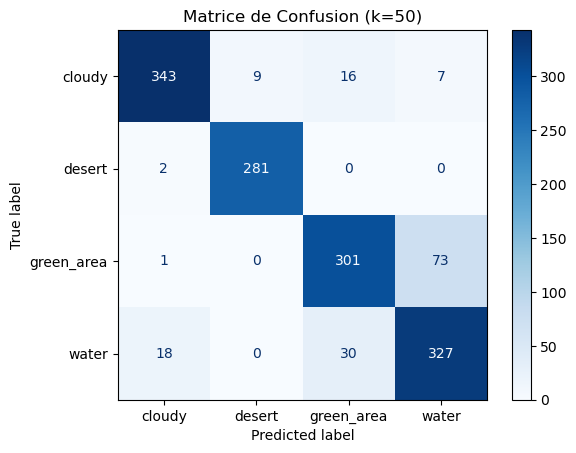

In [66]:
# TO DO: compute and plot the confusion matrix for the test set

# 1. On force la liste des classes pour être sûr d'avoir les 4 du Satellite
# (Cela corrige votre erreur de taille 2 vs 4)
class_names = ["cloudy", "desert", "green_area", "water"]

# 2. Création de la matrice
cm = confusion_matrix(y_test, y_pred)

# 3. Affichage graphique
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matrice de Confusion (k={best_k})")
plt.show()

<div class="alert alert-info">
<b>[QUESTION 2] Model evaluation</b>  <br>
    
- What can you say about the performance of your model?
- Is k-NN a good algorithm to classify these images?
- Why are some of the labels better classified than others? Give an intuitive explanation, and link it to the accuracy and confusion matrix.
    
(Expected answer length: &le; 9 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 2] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

We also ask you to produce a ROC curve to evaluate your classifier. In the course, we've seen how to do this for binary classification, i.e., when there are only two classes to differentiate. Here, there are more than two classes, and the method used must be adapted. In practice, there are several ways to do this, but here we ask you to use a One-vs-Rest strategy as explained in the link [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). The idea is to compare each class against all the other classes considered as one, thus reverting to binary classification. Then, to evaluate the classifier as a whole, the results for each class can be averaged (see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)).

We ask you to one **produce a multi-class ROC plot** containing: 
- A One-vs-Rest (OvR) ROC curve, for each class (4 curves)
- A ROC curve using the OvR micro-average (1 curve)
- A ROC curve using the OvR macro-average (1 curve)

On the plot, indicate the value of the area under the curve (AUC) for each curve.

In [50]:
# TO DO: plot the multi-class ROC curves (in a single figure)
...

<div class="alert alert-info">
<b>[QUESTION 3] ROC Curve</b>  <br>

- Can you make the link between these ROC curves and the confusion matrix above?
- What is the difference between micro- and macro-average in this context?
- What information can you infer from the fact that both the micro- and macro-average curves are close to the upper left part of the figure?

(Expected answer length: &le; 12 lines).
</b>
</div>


<div class="alert alert-success">
<b>[QUESTION 3] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

# **Part I.3 - Classification using k-means**

In this third part, you are asked to cluster your dataset using the k-means algorithm. Even though K-Means is an unsupervised algorithm, it can still be informative and useful in a supervised learning setting. The key idea is that unsupervised structure can reveal information that helps classification. To do that, first **scale your dataset**. 

In [51]:
# TO DO: Standardize your dataset
x_train_scaled = ...
x_test_scaled = ...

Now, **train a k-means clustering model**. Train it with `20` different centroid seeds. Again, make sure to set a [random seed](https://en.wikipedia.org/wiki/Random_seed) to ensure reproducibility. 

In [52]:
# TO DO: instantiate a k-means clustering model and train it on the satellite dataset
kmeans = KMeans(...)

In order to transform a clustering model into a classifier, we need to assign each cluster to a label. To do that, use your training set and perform a **majority vote**. That means, assign each cluster to the label that is the most present in it. 

In [53]:
# TO DO: assign a label to each cluster
...

<div class="alert alert-info">
<b>[QUESTION 4] Supervised or unsupervised?</b>  <br>
Is this way of using k-means supervised or unsupervised? Justify. (Expected answer length: &le; 3 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 4] Answer</b>  <br> 
**Insert your answer here.**
</b>
</div>

Now that you have a model, **evaluate it** in the following way: 
- Compute the accuracy of your model on your testing set using the assignment computed at the last step. 
- Plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [54]:
# TO DO: compute the accuracy on the testing set
accuracy = ...
print("The accuracy of the model is ", accuracy, "%")

The accuracy of the model is  Ellipsis %


In [55]:
# TO DO: compute and plot the confusion matrix for the test set
cm = ...

# **Part I.4 - PCA**

In order to interpret the results above, we will try to visualize the dataset. **Reduce the dimensionality** of the entire dataset to 3 dimensions using **Principal Component Analysis (PCA)**. You can restrict your analysis to the training set.

In [56]:
# TO DO: use PCA on the dataset
x_train_reduced = ...

<div class="alert alert-info">
<b>[QUESTION 5] PCA</b>  <br>
    
- Why is it important to standardize the dataset before applying a PCA?
- Should you compute the eigenvectors of the **covariance** or the **correlation**?
    
In your answer, include an explanation in the context of this very dataset, i.e. $(R, G, B, A)$ images. (Expected answer length: &le; 7 lines).

</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 5] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

**Make a 3D plot** of the reduced dataset. 

In [57]:
# TO DO: Make a 3D plot of the reduced dataset.

<div class="alert alert-info">
<b>[QUESTION 6] Interpretation of k-means results</b>  <br>

- Interpret the results of the k-means clustering algorithm. Make the link between these results and the 3D plot above. 
- Is it a good idea to use k-means here?

(Expected answer length: &le; 9 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 6] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

<br><font size=7 color=#009999> <b>PART II - Dogs and Cats</b> </font> <br><br>

<img src="datasets/cats_and_dogs/dogs/dog_0.jpg" alt="Drawing" style="width: 400px;"/> <img src="datasets/cats_and_dogs/cats/cat_3.jpg" alt="Drawing" style="width: 400px;"/>

In this second part, we will try to use similar methods for the classification of **pictures of dogs and cats**. In particular, we will
- Pre-process the dataset
- Train a k-NN classifier, and evaluate it
- Use PCA to visualize the dataset

Then, we will compare how these methods perform compared to the first dataset. 

# **Part II.1 - Pre-processing**

**Pre-process the dataset** in the same fashion as the first dataset. That is, produce a `pd.DataFrame` (see [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) whose rows correspond to images, and whose columns contain either the RGBA value of a pixel or the label of the image.

In [58]:
# TO DO: fill the dataframe with the Cats&Dogs images
DATA_PATH = "datasets/cats_and_dogs"
LABEL_TO_IDX = {"cats": 0, "dogs": 1}

df = pd.DataFrame(...)

print(df.describe())

ValueError: DataFrame constructor not properly called!

# **Part II.2 - k-NN classification**

**Train a k-NN classifier** in the same fashion as for the first dataset. 

In [ ]:
# TO DO: train a k-NN classifier on this dataset

...

**Evaluate your k-NN classifier** by 
- Computing the accuracy
- Plotting the Confusion Matrix
- Plotting the ROC Curve

In [ ]:
# TO DO: compute the accuracy on the test set
accuracy = ...
print("The accuracy of the model is ", accuracy, "%")

In [ ]:
# TO DO: compute and plot the confusion matrix for the test set
cm = ...

In [ ]:
# TO DO: plot the ROC curve of your k-NN classifier
...

# **Part II.3 - PCA**

In order to have further insight about this dataset, **reduce the dimension** of the dataset to 3 dimensions using **Principal Component Analysis (PCA)**. Again, your analysis can be restricted to the training set. 

In [ ]:
# TO DO: use PCA on the dataset
x_train_reduced = ...

Make the same 3D plot as above. 

In [ ]:
# TO DO: make a 3D plot of the reduced dataset.
...

<div class="alert alert-info">
<b>[QUESTION 7] Analysis of the results on this dataset</b>  <br>
Is there a difference of performance between the k-NN trained on the first dataset (satellite image) and the second dataset (cats and dogs)? If so, highlight the main visual difference between the appearance of the images of the first and second datasets that could explain such a difference in performance and the difficulty level of the considered classification problem. Be precise, and make the link between your explanation and the accuracy, confusion matrix, ROC curve and PCA plot. (Expected answer length: &le; 9 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 7] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

<br><font size=7 color=#009999> <b>PART III - Hyperspectral images</b> </font> <br><br>

<img src="figures/salinas_1.png" alt="Drawing" style="width: 400px;"/> <img src="figures/salinas_2.png" alt="Drawing" style="width: 400px;"/>

We will now train and test our model on a hyperspectral image collected by the AVIRIS sensor over Salinas Valley, California.
This dataset is a classic benchmark in remote sensing, containing agricultural fields with 16 labeled classes, including vegetables, bare soil, and vineyards. The raw image has 224 spectral bands, of which 20 noisy water-absorption bands have been removed, leaving **204 effective bands**. The final image has a spatial resolution of **512 lines × 217 samples**.

Unlike ordinary RGB images, which record only three broad color channels (red, green, blue), hyperspectral images capture **hundreds of narrow spectral bands**, each corresponding to a specific wavelength. This fine spectral resolution reveals subtle material and chemical differences that ordinary color cannot.

To visualize this structure, consider the hyperspectral cube below.
Each pixel $(x,y)$ in the spatial plane contains an entire spectrum across wavelengths $\lambda$. 
The curve on the right illustrates this spectral signature, which quantifies how that pixel reflects or absorbs light across the electromagnetic spectrum.

We invite you to spend a few minutes to learn more about the [Salinas dataset](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes).

<img src="figures/HSI_diagram.png" alt="Drawing" style="width: 400px;"/>

# **Part III.1 - Pre-processing**

With RGB/RGBA images, we had multiple separate images, each with a single label (e.g., "dog" or "cat").

With the hyperspectral image, you have one large image: **you’ll crop it into smaller spatial patches** (e.g. groups of pixels), **split the collection of these patches into training and testing sets**, and **classify each patch based on its spectral signature**. The key difference is that you’re working with spatial regions of a single image rather than independent images.

For the hyperspectral image, you are given:

- A single large image (`img`) with height `H`, width `W`, and `B` spectral bands.
- A corresponding ground truth label map (`gt`) of the same height and width, where each pixel’s value indicates its class (e.g., 1 for forest, 2 for water, etc.), and 0 means background (to be ignored).

In [ ]:
from scipy.io import loadmat

# Load data
data = loadmat('datasets/hyperspectral/hyperspectral.mat')
gt_data = loadmat('datasets/hyperspectral/hyperspectral_gt.mat')

img = data['salinas_corrected']  # shape: H x W x B
gt = gt_data['salinas_gt']       # shape: H x W, 0 = background

H, W, B = img.shape

Your tasks are the following: 

1. Flatten the image cube into a 2D array of pixels. After flattening, each row of the array corresponds to one pixel, and each column represents a wavelength band. In other words, every row gives the spectral signature (intensity vs. wavelength) for one spatial location $(x,y)$ in the image cube. The above diagram of a hyperspectral cube may be helpful.

2. Flatten the label image in the same way so that each label matches the corresponding pixel.

3. Remove background pixels (where the label value is 0), keeping only labeled pixels.

4. Shuffle the remaining labeled pixels and split them into training (75%) and test (25%) sets.

In [ ]:
# TO DO: divide your dataset into training and testing sets, according to the methodology described above.
X_train, y_train = ...
X_test, y_test = ...

# **Part III.2 - k-NN classification**

**Train a k-NN classifier** with `k = 5` and the `euclidean` distance. Before training it, you should **normalize** the rows of your dataset.

<div class="alert alert-warning">
<b>[NOTE] Normalization</b>  <br>

Let $X \in \mathbb{R}^{N \times d}$ be your dataset, with $N$ data points and $d$ features (columns).  It can be written as $X = (x_1, \dots ,x_N)^\top$ where $x_i \in \mathbb{R}^d$.

A row $x_i$ can be normalized if it is replaced by $z_i = x_i / \|x_i\|$.  
A dataset is normalized if all its rows are normalized. 

</div>

<div class="alert alert-info">
<b>[QUESTION 8] Normalization</b>  <br>
In this example, when using the Euclidean distance, why is normalization important?  Explain your reasoning in terms of the spectral features of the pixels (their "shape" and "intensity").

<i>Hint:</i> The Euclidean distance is sensitive to the <b>magnitude</b> of the vectors. 

<i>Hint:</i> You may find it helpful to have another look at the spectral signature subplot of the hyperspectral cube diagram.

(Expected answer length: &le; 8 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 8] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

In [ ]:
# TO DO: normalize the rows of your dataset, and train a k-NN classifier on the training set
...

**Compute the accuracy** of your classifier. 

In [ ]:
# TO DO: compute the accuracy of the classifier
accuracy = ...
print("The accuracy of the model is ", accuracy, "%")

**Visualize the train and test pixel locations on the ground truth map**. Color the testing pixels in green, the training pixels in red and the background in white. 

In [ ]:
# TO DO: visualize the train/test pixel coordinates
...

<div class="alert alert-info">
<b>[QUESTION 9] Distribution of the training and testing</b>  <br>
    
- What do you notice about how the training and test pixels are distributed spatially?
- Knowing that this model should generalize to other hyperspectral images in the future, is this sampling strategy good? Justify.

(Expected answer length: &le; 5 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 9] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

# **Part III.3 - k-NN classification with block-based sampling**

This time, we will try a different approach. Instead of using the spectrum of each pixel, we will **divide the image into spatial blocks**, and use the center pixel of each block for classification. 

Your tasks are the following:

1. Extract patches of size 3x3 pixels. For each patch, only the center pixel is used for classification.
2. Skip background pixels (where gt == 0).
3. Collect the spectral vector of each center pixel, along with its label.
4. Split the data into training (75%) and testing (25%) sets. Be careful: make sure that the class distribution is preserved in both subsets (i.e., each class should appear in similar proportions in the training and testing sets).

In [ ]:
# TO DO: divide your dataset into training and testing sets, according to the methodology described above.
X_train, y_train = ...
X_test, y_test = ...

**Visualize the train and test pixel locations on the ground truth map**. Color the testing pixels in green, the training pixels in red and the background in white. 

In [ ]:
# TO DO: visualize the train/test pixel coordinates
...

**Train a k-NN classifier** with `k = 5` and the `euclidean` distance. Before training it, you should **normalize** the rows of your dataset.

In [ ]:
# TO DO: normalize the rows of your dataset, and train a k-NN classifier on the training set
...

**Compute the accuracy** of your model. 

In [ ]:
# TO DO: compute the accuracy of the classifier
accuracy = ...
print("The accuracy of the model is ", accuracy, "%")

<div class="alert alert-info">
<b>[QUESTION 10] Block-based sampling</b>  <br>
Re-run your code using spatial blocks of 5×5 pixels, then 7×7.

- How does the accuracy change as the block size increases?
- Considering that the classifier should generalize to other hyperspectral images, do larger block sizes lead to better generalization?

(Expected answer length: &le; 5 lines).
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 10] Answer</b>  <br>
**Insert your answer here.**
</b>
</div>

# **Part IV - Conclusion**

<div class="alert alert-info">
<b>[QUESTION 11] Conclusion</b>  <br>
You must explain this project to an EPL student who has not taken the course using an illustration explaining the pre-processing to be implemented for these images (dimension management, RGB/RGB-A, etc.) and summarize one of the three parts (Satellite, dogs & cats or hyperspectral). You are free to create the illustration however you wish (as a slide or a diagram for example). It must only be included directly in this Jupyter notebook as an image or PDF file.
</b>
</div>

<div class="alert alert-success">
<b>[QUESTION 11] Answer</b>  <br>
...
</b>
</div>